In [1]:
import pandas as pd
import json
from transformers import AutoTokenizer
from datasets import load_dataset

/home/is/davide-r/.pyenv/versions/3.12.8/envs/beer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

0.95**768

7.793433999520637e-18

In [2]:
def jaccard_similarity(L1, L2):
    return len(set(L1) & set(L2)) / len(set(L1) | set(L2))


In [3]:
tokenizer = AutoTokenizer.from_pretrained("rv2307/electra-small-ner")
data = load_dataset("xiaobendanyn/tacred", split = "test")
df = pd.DataFrame([json.loads(d['text']) for d in data]).map(lambda x: x['name'] if isinstance(x, dict) else " ".join(x) if isinstance(x, list) else x)
df.rename(columns = {"token": "input", "relation": "label"}, inplace = True)
df["h_tokens"] = df["h"].apply(lambda x: tokenizer.tokenize(x, add_special_tokens = False))
df["t_tokens"] = df["t"].apply(lambda x: tokenizer.tokenize(x, add_special_tokens = False))
df.head()

,input,h,t,label,h_tokens,t_tokens
0,The National Congress of American Indians was ...,National Congress of American Indians,1944,org:founded,"[national, congress, of, american, indians]",[1944]
1,UASR was founded in 1989 by Mousa abu Mazook <...,UASR,1989,org:founded,"[ua, ##sr]",[1989]
2,"Founded in 1951 , PATA is a non-profit members...",PATA,1951,org:founded,"[pat, ##a]",[1951]
3,The Securities and Exchange Commission schedul...,Countrywide,1969,org:founded,"[country, ##wide]",[1969]
4,"MEF , which was founded in 1991 , has grabbed ...",MEF,1991,org:founded,"[me, ##f]",[1991]


In [4]:
results = pd.read_json("../src/results/tacred_scores_NuNER-v2.0.json")
results["tokenized"] = results["original_text"].apply(lambda x: tokenizer.tokenize(x, add_special_tokens = False))
results["e_i_tokens"] = results.apply(lambda row: row["tokenized"][row["e_i_idx"][0]:row["e_i_idx"][1]], axis = 1)
results["e_j_tokens"] = results.apply(lambda row: row["tokenized"][row["e_j_idx"][0]:row["e_j_idx"][1]], axis = 1)
results = results.loc[results["e_j_tokens"].apply(len) > 1,:]
results.head()

,e_i_idx,e_j_idx,e_i_tokens,e_j_tokens,score,original_text,doc_number,tokenized
0,"[0, 8]","[9, 25]","[the, national, congress, of, american, indian...","[1944, in, response, to, assimilation, policie...",NaN,The National Congress of American Indians was ...,0,"[the, national, congress, of, american, indian..."
1,"[0, 23]","[24, 32]","[ua, ##sr, was, founded, in, 1989, by, mo, ##u...","[##ject, ##org, /, profile, /, 106, >, ,]",1.0,UASR was founded in 1989 by Mousa abu Mazook <...,3,"[ua, ##sr, was, founded, in, 1989, by, mo, ##u..."
2,"[0, 23]","[35, 38]","[ua, ##sr, was, founded, in, 1989, by, mo, ##u...","[as, the, deputy]",0.0,UASR was founded in 1989 by Mousa abu Mazook <...,3,"[ua, ##sr, was, founded, in, 1989, by, mo, ##u..."
3,"[0, 23]","[39, 48]","[ua, ##sr, was, founded, in, 1989, by, mo, ##u...","[of, the, hamas, political, bureau, in, damasc...",1.0,UASR was founded in 1989 by Mousa abu Mazook <...,3,"[ua, ##sr, was, founded, in, 1989, by, mo, ##u..."
4,"[24, 32]","[35, 38]","[##ject, ##org, /, profile, /, 106, >, ,]","[as, the, deputy]",1.0,UASR was founded in 1989 by Mousa abu Mazook <...,3,"[ua, ##sr, was, founded, in, 1989, by, mo, ##u..."


In [5]:
# Joint df and results on rows that have input==original_text and jaccard_similarity(h_tokens, e_i_tokens) >= 0.5 and jaccard_similarity(t_tokens, e_j_tokens) >= 0.5
jaccard_threshold = 0.333
all_scores = []
for i,row in results.iterrows():
    text_match = df.loc[df["input"] == row["original_text"]]
    if text_match.shape[0] > 0:
        h_match = text_match["h_tokens"].apply(lambda x: jaccard_similarity(x, row["e_i_tokens"]) >= jaccard_threshold)
        t_match = text_match["t_tokens"].apply(lambda x: jaccard_similarity(x, row["e_j_tokens"]) >= jaccard_threshold)
        both_matches = h_match & t_match
        if both_matches.any():
            match_scores = [(1,row["score"])]*sum(both_matches) + [(0,row["score"])]*(len(text_match)-sum(both_matches))
        else:
            match_scores = [(0,row["score"])]*len(text_match)
    all_scores.extend(match_scores)

y_true            0          1
count   5493.000000  50.000000
mean       0.870157   0.778449
std        0.332642   0.405655
min        0.000000   0.000000
25%        1.000000   0.952315
50%        1.000000   1.000000
75%        1.000000   1.000000
max        1.000000   1.000000


<Axes: >

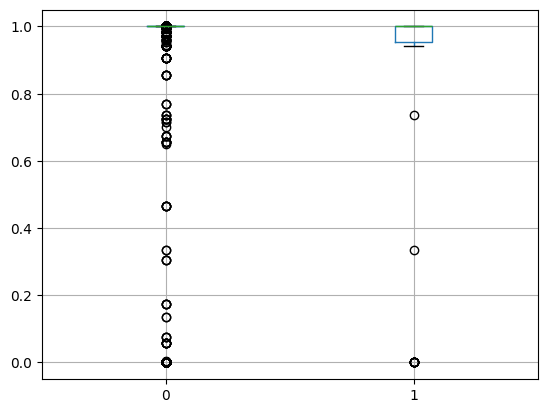

In [6]:
pivot_table = pd.DataFrame(all_scores, columns = ["y_true", "y_pred"]).pivot(columns = "y_true", values = "y_pred")
print(pivot_table.describe())
pivot_table.boxplot()